# Rakan's Playground




## Setup

### Package Installing

In [1]:
!pip install spotipy

### Google Drive & Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
PROJECT_ROOT = '/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

### Internal Imports

In [4]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, SpotifyTracksDataset, normalize_data_by_type, normalize_data, NormalizationType

In [5]:
sp = get_spotify_connection()

### PyTorch/Numpy/Pandas

In [6]:
import numpy as np
import pandas as pd
import random

pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

## Loading Data

In [9]:
pl = PL.load_playlist(PROJECT_ROOT + "playlist_2sRZldX6n9oaII70OoO3zB")

Loaded playlist from file: /content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/playlist_2sRZldX6n9oaII70OoO3zB


In [72]:
information_df = pd.DataFrame()

In [136]:
''' Audio Features '''
information_df['key'] = pd.Series([x['key'] for x in pl.playlist_information.track_features.values])
information_df['mode'] = pd.Series([x['mode'] for x in pl.playlist_information.track_features.values])
information_df['time_signature'] = pd.Series([x['time_signature'] for x in pl.playlist_information.track_features.values])
information_df['duration'] = pd.Series([x['duration_ms'] / 1000 for x in pl.playlist_information.track_features.values])
information_df['acousticness'] = pd.Series([x['acousticness'] for x in pl.playlist_information.track_features.values])
information_df['danceability'] = pd.Series([x['danceability'] for x in pl.playlist_information.track_features.values])
information_df['energy'] = pd.Series([x['energy'] for x in pl.playlist_information.track_features.values])
information_df['instrumentalness'] = pd.Series([x['instrumentalness'] for x in pl.playlist_information.track_features.values])
information_df['liveness'] = pd.Series([x['liveness'] for x in pl.playlist_information.track_features.values])
information_df['loudness'] = pd.Series([x['loudness'] for x in pl.playlist_information.track_features.values])
information_df['speechiness'] = pd.Series([x['speechiness'] for x in pl.playlist_information.track_features.values])
information_df['valence'] = pd.Series([x['valence'] for x in pl.playlist_information.track_features.values])
information_df['tempo'] = pd.Series([x['tempo'] for x in pl.playlist_information.track_features.values])

''' Track Info '''
information_df['explicit'] = pd.Series([x['explicit'] for x in pl.playlist_information.track_info.values])
information_df['release_date'] = pd.Series([x['album']['release_date'] for x in pl.playlist_information.track_info.values])

''' Artist Info '''
information_df['artist_followers'] = pd.Series([np.array([x['followers']['total'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
information_df['max_artist_popularity'] = pd.Series([np.array([x['popularity'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
information_df['avg_popularity_artist_top_tracks'] = pl.artist_top_track_information_df['avg_popularity_artist_top_tracks']
information_df['avg_duration_artist_top_tracks'] = pl.artist_top_track_information_df['avg_duration_artist_top_tracks']
information_df['avg_acousticness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks']
information_df['avg_danceability_artist_top_tracks'] = pl.artist_top_track_information_df['avg_danceability_artist_top_tracks']
information_df['avg_energy_artist_top_tracks'] = pl.artist_top_track_information_df['avg_energy_artist_top_tracks']
information_df['avg_instrumentalness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks']
information_df['avg_liveness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_liveness_artist_top_tracks']
information_df['avg_loudness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_loudness_artist_top_tracks']
information_df['avg_speechiness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks']
information_df['avg_valence_artist_top_tracks'] = pl.artist_top_track_information_df['avg_valence_artist_top_tracks']
information_df['avg_tempo_artist_top_tracks'] = pl.artist_top_track_information_df['avg_tempo_artist_top_tracks']

information_df['change_from_avg_duration_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_duration_artist_top_tracks'] - information_df.duration).abs()
information_df['change_from_avg_acousticness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks'] - information_df.acousticness).abs()
information_df['change_from_avg_danceability_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_danceability_artist_top_tracks'] - information_df.danceability).abs()
information_df['change_from_avg_energy_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_energy_artist_top_tracks'] - information_df.energy).abs()
information_df['change_from_avg_instrumentalness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks'] - information_df.instrumentalness).abs()
information_df['change_from_avg_liveness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_liveness_artist_top_tracks'] - information_df.liveness).abs()
information_df['change_from_avg_loudness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_loudness_artist_top_tracks'] - information_df.loudness).abs()
information_df['change_from_avg_speechiness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks'] - information_df.speechiness).abs()
information_df['change_from_avg_valence_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_valence_artist_top_tracks'] - information_df.valence).abs()
information_df['change_from_avg_tempo_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_tempo_artist_top_tracks'] - information_df.tempo).abs()

''' Target '''
information_df['popularity'] = pd.Series([x['popularity'] for x in pl.playlist_information.track_info.values])


''' Genres '''
genres_df = pl.genres_df

In [137]:
target = 'popularity'
features = list(information_df.columns.copy())
features.remove(target)
print(f"Features: {features}")
genres = list(genres_df.columns.copy())
print(f"Genres: {genres}")

regression_target = "popularity"
classification_target = "hit"
print(f"Regression Target: {regression_target}")
print(f"Classification Target: {classification_target}")

Features: ['key', 'mode', 'time_signature', 'duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'explicit', 'release_date', 'artist_followers', 'max_artist_popularity', 'avg_popularity_artist_top_tracks', 'avg_duration_artist_top_tracks', 'avg_acousticness_artist_top_tracks', 'avg_danceability_artist_top_tracks', 'avg_energy_artist_top_tracks', 'avg_instrumentalness_artist_top_tracks', 'avg_liveness_artist_top_tracks', 'avg_loudness_artist_top_tracks', 'avg_speechiness_artist_top_tracks', 'avg_valence_artist_top_tracks', 'avg_tempo_artist_top_tracks', 'change_from_avg_duration_artist_top_tracks', 'change_from_avg_acousticness_artist_top_tracks', 'change_from_avg_danceability_artist_top_tracks', 'change_from_avg_energy_artist_top_tracks', 'change_from_avg_instrumentalness_artist_top_tracks', 'change_from_avg_liveness_artist_top_tracks', 'change_from_avg_loudness_artist_top_tracks', 'change_from_avg_speechin

## Cleaning Data


In [138]:
df = information_df.copy()


''' Discrete''' 
df.time_signature = normalize_data_by_type(df.time_signature, NormalizationType.DEFAULT)
df.key = normalize_data_by_type(df.key, NormalizationType.DEFAULT)
df.explicit = df.explicit *1
df.release_date = 2020 - pd.to_datetime(df.release_date).dt.year
df.release_date = normalize_data_by_type(df.release_date, NormalizationType.DEFAULT)

''' Continuous'''
df.duration = normalize_data_by_type(df.duration, NormalizationType.STD_CLAMP)
df.avg_duration_artist_top_tracks = normalize_data_by_type(df.avg_duration_artist_top_tracks, NormalizationType.STD_CLAMP)
df.change_from_avg_duration_artist_top_tracks = normalize_data(df.change_from_avg_duration_artist_top_tracks, data_min=0, data_max=information_df.duration.max()-information_df.duration.min())

df.tempo = normalize_data_by_type(df.tempo,NormalizationType.DEFAULT)
df.avg_tempo_artist_top_tracks = normalize_data(df.avg_tempo_artist_top_tracks, data_min=information_df.tempo.min(), data_max=information_df.tempo.max())
df.change_from_avg_tempo_artist_top_tracks = normalize_data(df.change_from_avg_tempo_artist_top_tracks, data_min=0, data_max=information_df.tempo.max()-information_df.tempo.min())

df.loudness = normalize_data_by_type(df.loudness, NormalizationType.DEFAULT)
df.avg_loudness_artist_top_tracks = normalize_data(df.avg_loudness_artist_top_tracks, data_min=information_df.loudness.min(), data_max=information_df.loudness.max())
df.change_from_avg_loudness_artist_top_tracks = normalize_data(df.change_from_avg_loudness_artist_top_tracks, data_min=0, data_max=information_df.loudness.max()-information_df.loudness.min())

df.artist_followers = normalize_data_by_type(df.artist_followers, NormalizationType.DEFAULT)

df.max_artist_popularity = normalize_data(df.max_artist_popularity, data_min=0, data_max=100)
df.avg_popularity_artist_top_tracks = normalize_data(df.avg_popularity_artist_top_tracks, data_min=0, data_max=100)

# full_df = df

''' Add genre data '''
full_df = pd.concat([df, genres_df], axis=1, sort=False)

''' Drop missing data '''
full_df.dropna(inplace=True)

regression_df = full_df.copy()
# regression_df = regression_df[regression_df.popularity > 10]

classification_df = full_df.copy()
classification_df['hit'] = (classification_df.popularity > 50)*1
classification_df = classification_df.drop("popularity", axis=1)

print(f"Total Number of Tracks: {regression_df.shape[0]}")

print("\n")

print(f"Number of Hits: {classification_df.hit.sum()}")
print(f"Total Number of Tracks: {classification_df.shape[0]}")

Total Number of Tracks: 5493


Number of Hits: 2506
Total Number of Tracks: 5493


## Exploring Data

In [139]:
cols = list(information_df.columns)

exploring = regression_df.copy()[cols]

# cols_to_drop = [index if abs(value) < 0.1 else None for index, value in exploring.corr()['popularity'].iteritems()]
# cols_to_drop = list(filter(None, cols_to_drop)) 
# print(cols_to_drop)
# exploring.drop(cols_to_drop, axis=1, inplace=True)

exploring.corr()['popularity']

key                                                   0.008267
mode                                                 -0.015747
time_signature                                        0.070772
duration                                             -0.206862
acousticness                                         -0.220621
danceability                                          0.281782
energy                                                0.204053
instrumentalness                                     -0.445415
liveness                                              0.057070
loudness                                              0.339131
speechiness                                           0.131467
valence                                               0.245658
tempo                                                 0.078005
explicit                                              0.205866
release_date                                         -0.044490
artist_followers                                      0

In [140]:
def plot_feature_and_target(dataframe_to_plot, feature, target):
  cols = [feature, target]
  dataframe_to_plot = dataframe_to_plot[cols]
  dataframe_to_plot.plot.scatter(x=feature, y=target)
  return

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


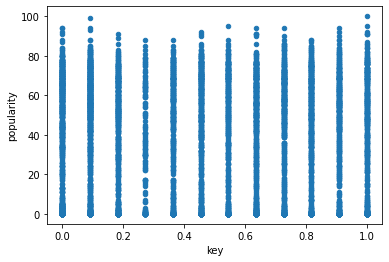

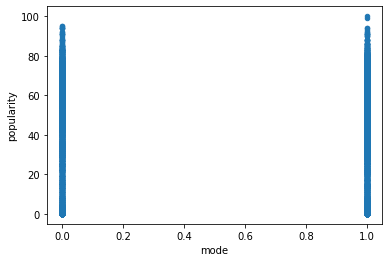

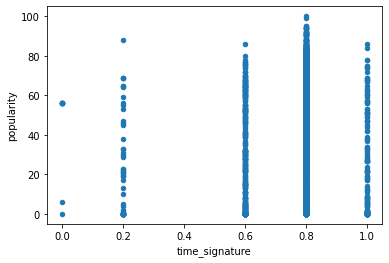

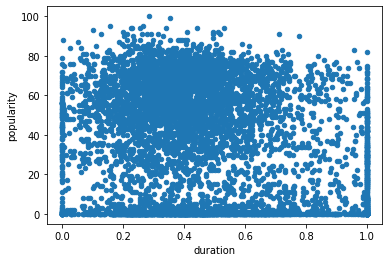

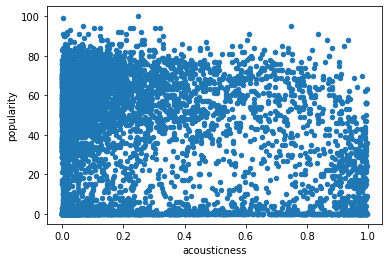

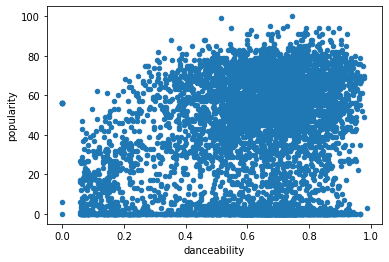

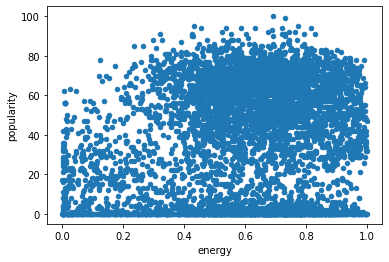

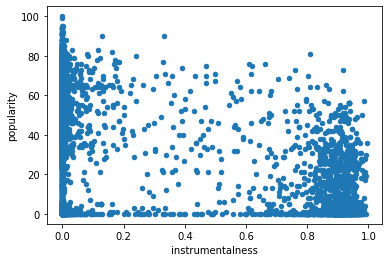

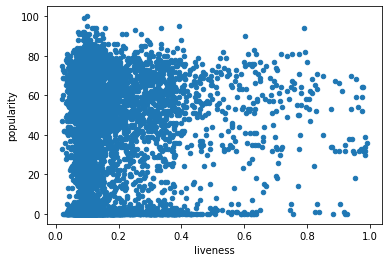

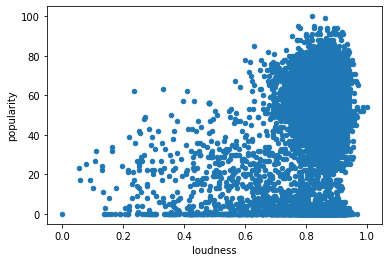

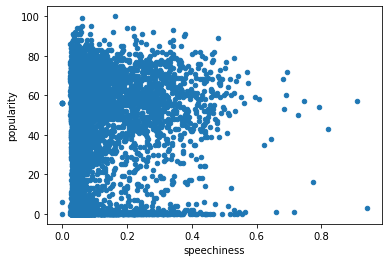

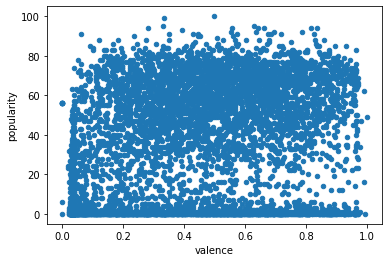

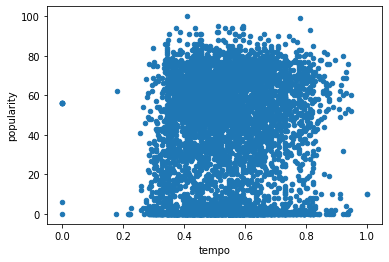

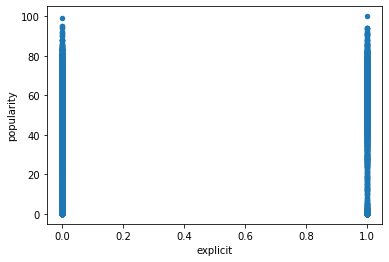

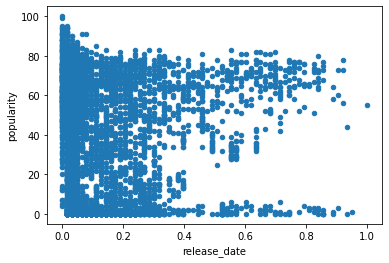

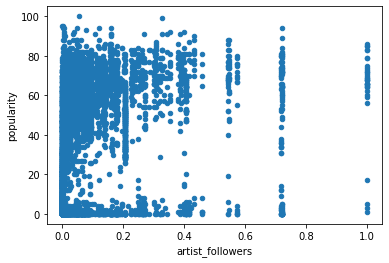

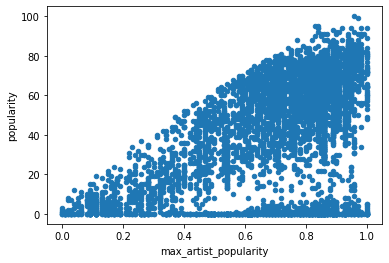

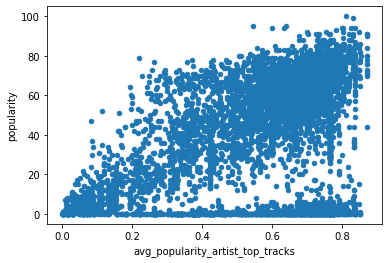

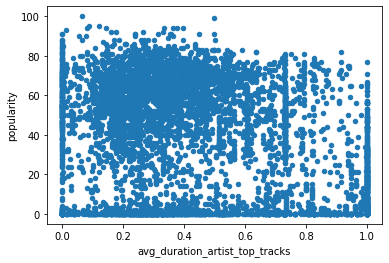

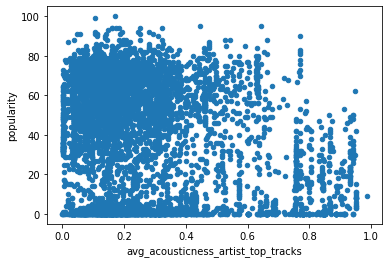

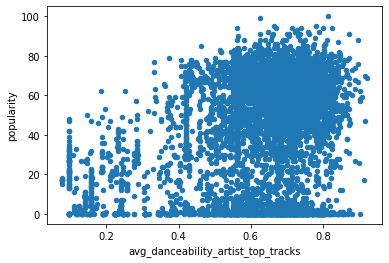

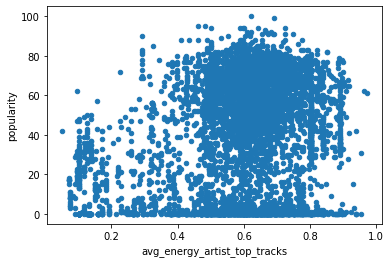

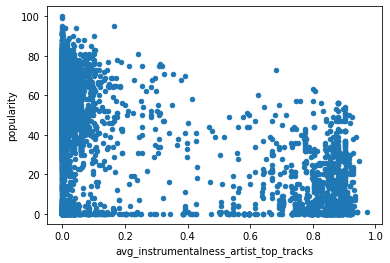

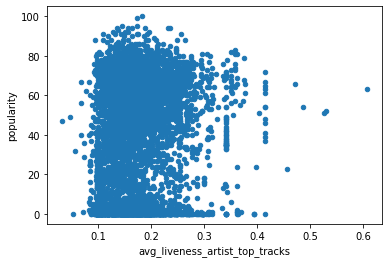

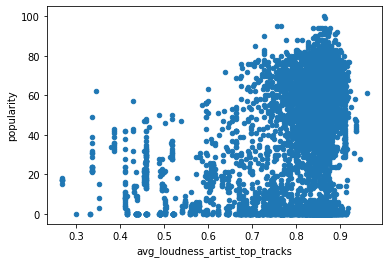

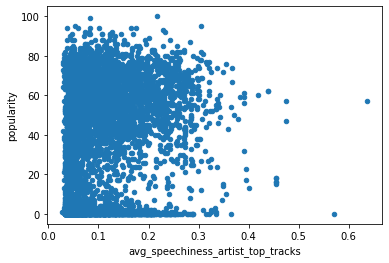

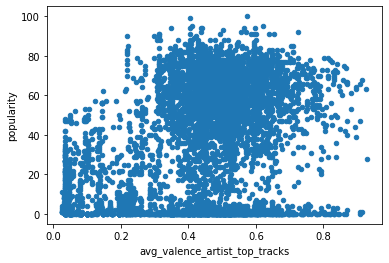

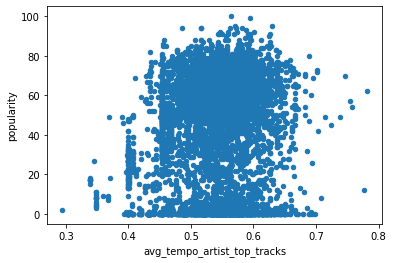

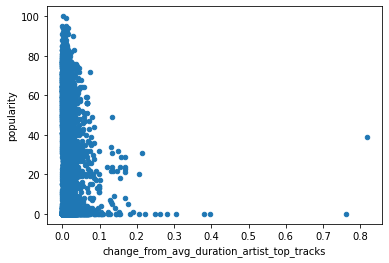

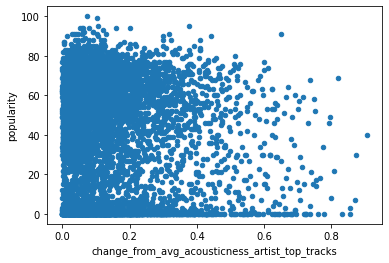

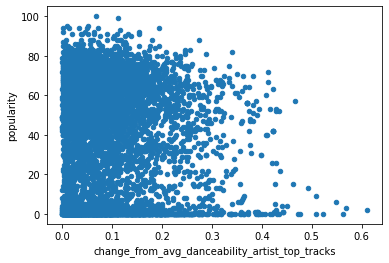

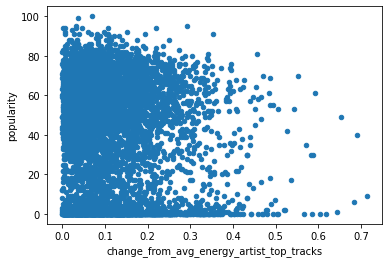

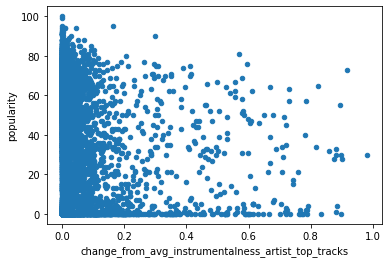

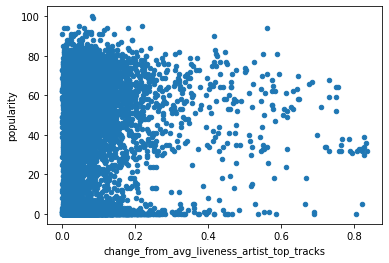

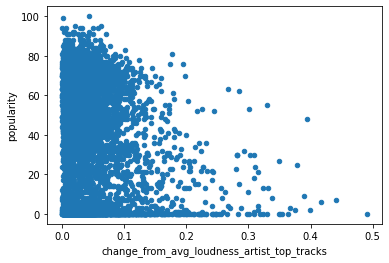

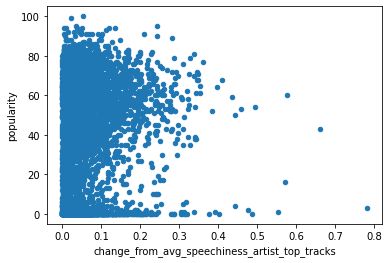

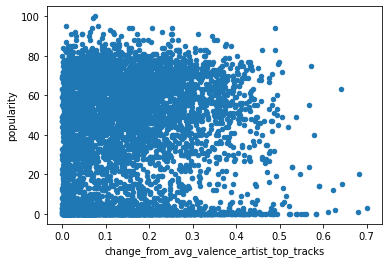

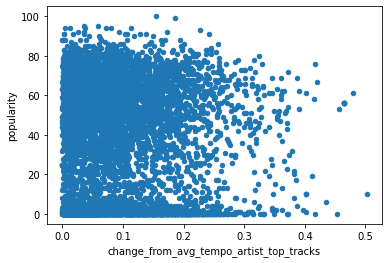

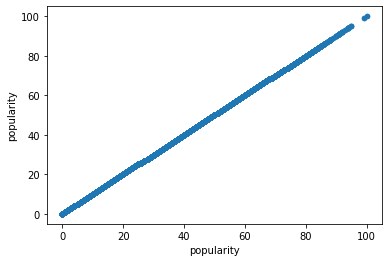

In [141]:
dataframe_to_plot = exploring
target = regression_target
for col in dataframe_to_plot.columns:
  plot_feature_and_target(dataframe_to_plot, col, target)

## Creating Dataset

In [142]:
TRAIN_PCT = 0.7
VALID_PCT = 0.15

dataframe_to_use = classification_df
dataset_target = classification_target
features = list(dataframe_to_use.columns.copy())
features.remove(dataset_target)

''' Scramble DataFrame '''
seed_torch(0)
dataframe_to_use = dataframe_to_use.sample(frac=1).reset_index(drop=True)

''' Split Data '''
num_data = dataframe_to_use.shape[0]

num_train = int(num_data * TRAIN_PCT)
num_val = int(num_data * VALID_PCT)
num_test = num_data - num_train - num_val

train_df = dataframe_to_use.iloc[0:num_train]
val_df = dataframe_to_use.iloc[num_train:num_train+num_val]
test_df = dataframe_to_use.iloc[num_train+num_val:num_data]

''' Create Datasets '''
train = SpotifyTracksDataset(train_df, features, dataset_target)
val = SpotifyTracksDataset(val_df, features, dataset_target)
test = SpotifyTracksDataset(test_df, features, dataset_target)

## Model

### Regression

In [49]:
class RegressionNet(nn.Module):
  def __init__(self):
    super(RegressionNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 500),
        nn.Tanh(),
        nn.Linear(500,250),
        nn.ReLU(),
        nn.Linear(250,100),
        nn.ReLU(),
        nn.Linear(100,25),
        nn.ReLU(),
        nn.Linear(25,1)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

### Classification

In [131]:
class ClassificationNet(nn.Module):
  def __init__(self):
    super(ClassificationNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.Dropout(0.5),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(50,2)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

## Training

### Helper Functions

In [51]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    k = random.randint(0, len(data)-1)
    features, target = data[k]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

In [52]:
import matplotlib.pyplot as plt

def subsample_series(series, subsampling=1):
  '''
  Subsamples data series
  '''
  indices = np.arange(0,len(series),subsampling)
  subsampled_series = series[indices]
  return indices + 1, subsampled_series

def plot_data(data, multiple_series=False, subsampling=1, labels=None, title="", xlabel="", ylabel=""):
    plt.title(title)
    
    n = len(data)

    if multiple_series:
      for i, series in enumerate(data, 0):
        indices, subsampled_series = subsample_series(np.array(series), subsampling=subsampling)
        if labels:
          plt.plot(indices, subsampled_series, label=labels[i])
        else:
          plt.plot(indices, subsampled_series,)
    else:
      indices, subsampled_series = subsample_series(np.array(data), subsampling=subsampling)
      if labels:
          plt.plot( indices, subsampled_series, label=labels)
      else:
        plt.plot( indices, subsampled_series)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if labels:
      plt.legend(loc='best')

    plt.show()

#### Regression

In [109]:
def get_error_regression(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)
  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  error_rate = total_error/len(data)
  return error_rate

def get_stats_regression(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0.0
  total_loss = 0.0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error = total_error/len(data)
  return error, avg_loss

#### Classification

In [110]:
def get_error_classification(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()
  
  error_rate = 1 - (total_error/len(data))
  return error_rate

def get_stats_classification(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0
  total_loss = 0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error_rate = 1 - (total_error/len(data))
  return error_rate, avg_loss

### Train Function

#### Regression

In [111]:
def train_net_regression(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0.0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = epoch_error / len(train_data)
    val_error_rate, val_loss = get_stats_regression(model, valid_data, criterion, bs=bs)
    model.train()

    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print()
    predict_some(model, train_data, 2)
    print()
    predict_some(model, valid_data, 2)
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Avg Error by Epoch", xlabel='Epoch', ylabel='Avg Error')

#### Classification

In [112]:
def train_net_classification(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)

      targets = targets.squeeze(1).long()
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      out = torch.softmax(out, dim=1)

      epoch_loss += loss.item()
      epoch_error += out.argmax(dim=1).eq(targets).sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = 1 - (epoch_error / len(train_data))
    val_error_rate, val_loss = get_stats_classification(model, valid_data, criterion, bs=bs)
    model.train()
    
    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Accuracy by Epoch", xlabel='Epoch', ylabel='Error Rate')

### Training Model

#### Regression

Epoch 1
  Train Error: 41.01664499349805
  Valid Error: 38.23572296476306
  Train Loss: 2464.568603515625
  Valid Loss: 2234.31884765625

Actual: 53.0;  Predicted: 0.0
Actual: 40.0;  Predicted: 0.0

Actual: 50.0;  Predicted: 0.0
Actual: 7.0;  Predicted: 0.0


Epoch 2
  Train Error: 41.01063576885566
  Valid Error: 38.209323739368166
  Train Loss: 2462.7940063476562
  Valid Loss: 2230.42041015625

Actual: 0.0;  Predicted: 0.04
Actual: 0.0;  Predicted: 0.03

Actual: 59.0;  Predicted: 0.03
Actual: 2.0;  Predicted: 0.03


Epoch 3
  Train Error: 40.96948350130039
  Valid Error: 38.14444581561361
  Train Loss: 2461.0775146484375
  Valid Loss: 2223.30029296875

Actual: 1.0;  Predicted: 0.13
Actual: 74.0;  Predicted: 0.16

Actual: 74.0;  Predicted: 0.13
Actual: 15.0;  Predicted: 0.13


Epoch 4
  Train Error: 40.88424089726918
  Valid Error: 38.01967364064399
  Train Loss: 2448.2213745117188
  Valid Loss: 2209.668212890625

Actual: 33.0;  Predicted: 0.31
Actual: 41.0;  Predicted: 0.27

Actual: 

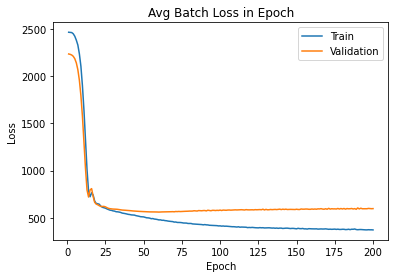

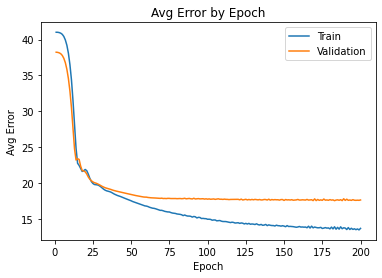

In [96]:
model = RegressionNet()
model.to(device)

train_net_regression(model, train, val, bs=1024, lr=0.0005, wd=0, epochs=200)

#### Classification

Epoch 1
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.6927046179771423
  Valid Loss: 0.6830018162727356


Epoch 2
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.6917900517582893
  Valid Loss: 0.6830035150051117


Epoch 3
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.6924401819705963
  Valid Loss: 0.6829874515533447


Epoch 4
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.6916245296597481
  Valid Loss: 0.6829494833946228


Epoch 5
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.6913346499204636
  Valid Loss: 0.6828882992267609


Epoch 6
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.690373420715332
  Valid Loss: 0.6827856004238129


Epoch 7
  Train Error: 0.46710013003901174
  Valid Error: 0.3985419198055893
  Train Loss: 0.6897411644458771
  Valid Loss: 0.68263

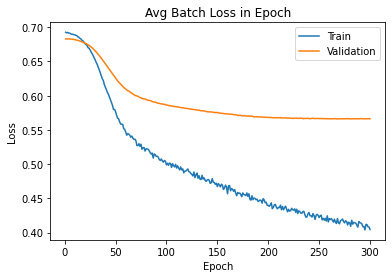

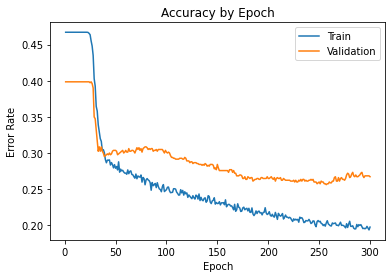

In [143]:
model = ClassificationNet()
model.to(device)

train_net_classification(model, train, val, bs=512, lr=0.00005, wd=0, epochs=300)

## Evaluation

In [34]:
def get_baseline_regression_error(df):
  total_error = 0
  errors = (df.max_artist_popularity*100 - df.popularity).abs()
  errors = (df.avg_popularity_artist_top_tracks*100 - df.popularity).abs()
  total_error = errors.sum()
  error_rate = total_error/df.shape[0]
  return error_rate

def get_baseline_classification_error(df):
  total_error = 0
  correct = (df.hit == (df.avg_popularity_artist_top_tracks*100 > 50)).sum()
  # correct = (df.hit == (df.max_artist_popularity*100 > 50)).sum()
  error_rate = 1 - (correct/df.shape[0])
  return error_rate

### Regression

In [85]:
error = get_error_regression(model, test)
print(error)

10.802569183101498


In [94]:
baseline_error = get_baseline_regression_error(train_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(val_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(test_df)
print(baseline_error)

baseline_error = get_baseline_regression_error(regression_df)
print(baseline_error)

19.919915253461415
20.68003212275486
20.30826438249911
20.092127926842924


### Classification

In [125]:
error = get_error_classification(model, test)
print(error)

0.30787878787878786


In [144]:
baseline_error = get_baseline_classification_error(train_df)
print(baseline_error)
baseline_error = get_baseline_classification_error(val_df)
print(baseline_error)
baseline_error = get_baseline_classification_error(test_df)
print(baseline_error)

baseline_error = get_baseline_classification_error(classification_df)
print(baseline_error)

0.29986996098829644
0.31834750911300125
0.3103030303030303
0.304205352266521
